Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 30.0 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
     |████████████████████████████████| 596 kB 62.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=344fe6c0a36b93a652ce40cd1196fba6d960f8e891e93e2c1e171a832feed8f1
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['O', 'I-test', 'B-treatment', 'B-problem', 'B-test', 'I-problem', 'I-treatment']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['O', 'I-test', 'B-treatment', 'B-problem', 'B-test', 'I-problem', 'I-treatment']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['O', 'I-test', 'B-treatment', 'B-problem', 'B-test', 'I-problem', 'I-treatment']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

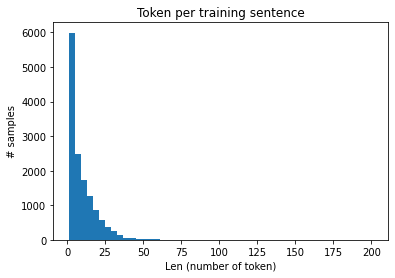

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

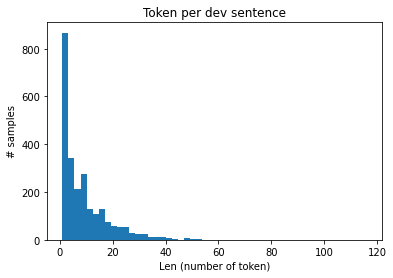

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

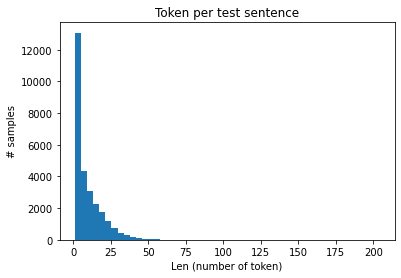

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

22032
interoperative
2
B-test


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.96394)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 500
Points in y_train before removal: 500


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[6931, 738, 11263]
[0, 0, 0]
[18987, 27932, 1290, 8424, 24962, 16429, 12311, 9028, 18411, 25534, 1007, 9555]
[3, 5, 5, 5, 5, 5, 0, 4, 1, 1, 1, 0]
[982, 24733, 11263]
[0, 0, 0]
22032
2
B-treatment
think
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 11.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.8 MB/s 
     |████████████████████████████████| 120 kB 67.3 MB/s 
     |████████████████████████████████| 6.6 MB 32.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=625f318daa64b81bdd5acc80871d29379cc552e378a942adb307beda77e87064
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[6931, 738, 11263]
[0, 0, 0]
[18987, 27932, 1290, 8424, 24

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.42824125289917
Training loss epoch: 0.863864466547966
Training accuracy epoch: 0.7518627951088355
Validating model...
Validation Loss: 0.5249145421888921
Validation Accuracy: 0.8366033709799374
Training epoch: 2
Training loss per 100 training steps: 0.47896844148635864
Training loss epoch: 0.35440456196665765
Training accuracy epoch: 0.8827322126114293
Validating model...
Validation Loss: 0.3193916915492578
Validation Accuracy: 0.8989813524067308
Training epoch: 3
Training loss per 100 training steps: 0.21588970720767975
Training loss epoch: 0.1446916528046131
Training accuracy epoch: 0.9566580168600464
Validating model...
Validation Loss: 0.26727520829284346
Validation Accuracy: 0.919451233574953
Training epoch: 4
Training loss per 100 training steps: 0.0531420037150383
Training loss epoch: 0.06376643031835556
Training accuracy epoch: 0.982591529210481
Validating model...
Validation Loss: 0.2512921200363667
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27290244835980787
Validation Accuracy: 0.9213293391268143
Validation duration: 5.884561416666666 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.0%
              precision    recall  f1-score   support

     problem       0.64      0.78      0.70     12546
        test       0.70      0.70      0.70      9012
   treatment       0.69      0.77      0.73      9297

   micro avg       0.67      0.76      0.71     30855
   macro avg       0.67      0.75      0.71     30855
weighted avg       0.67      0.76      0.71     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1937875747680664
Training loss epoch: 0.8322053343057633
Training accuracy epoch: 0.7572766966396736
Validating model...
Validation Loss: 0.49545036159552536
Validation Accuracy: 0.8442529151217414
Training epoch: 2
Training loss per 100 training steps: 0.3060323894023895
Training loss epoch: 0.3537101954221725
Training accuracy epoch: 0.8874771448222134
Validating model...
Validation Loss: 0.3229216964213879
Validation Accuracy: 0.8942936749548202
Training epoch: 3
Training loss per 100 training steps: 0.17130501568317413
Training loss epoch: 0.16993011087179183
Training accuracy epoch: 0.9450206528398292
Validating model...
Validation Loss: 0.2628860775526468
Validation Accuracy: 0.9174572268178128
Training epoch: 4
Training loss per 100 training steps: 0.057346075773239136
Training loss epoch: 0.06710415408015251
Training accuracy epoch: 0.9814056932194385
Validating model...
Validation Loss: 0.27750473537228326
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.270960688797964
Validation Accuracy: 0.9161206428985126
Validation duration: 5.7241047666666685 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 67.2%
              precision    recall  f1-score   support

     problem       0.64      0.72      0.68     12546
        test       0.67      0.68      0.67      9012
   treatment       0.63      0.71      0.67      9297

   micro avg       0.64      0.70      0.67     30855
   macro avg       0.64      0.70      0.67     30855
weighted avg       0.64      0.70      0.67     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9711135625839233
Training loss epoch: 0.8288398265838623
Training accuracy epoch: 0.7596246952109714
Validating model...
Validation Loss: 0.5327831957634394
Validation Accuracy: 0.8293185501444894
Training epoch: 2
Training loss per 100 training steps: 0.4529087543487549
Training loss epoch: 0.3696004211902618
Training accuracy epoch: 0.8859879752674858
Validating model...
Validation Loss: 0.3506320786553544
Validation Accuracy: 0.884017394747259
Training epoch: 3
Training loss per 100 training steps: 0.14756342768669128
Training loss epoch: 0.1601812969893217
Training accuracy epoch: 0.9522580305192612
Validating model...
Validation Loss: 0.32286591866573733
Validation Accuracy: 0.9039200218190946
Training epoch: 4
Training loss per 100 training steps: 0.04219195619225502
Training loss epoch: 0.07300104927271604
Training accuracy epoch: 0.9793510470957327
Validating model...
Validation Loss: 0.2805680352952573
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29101103894343533
Validation Accuracy: 0.9185632507352506
Validation duration: 5.738655349999999 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.4%
              precision    recall  f1-score   support

     problem       0.64      0.75      0.69     12546
        test       0.67      0.70      0.69      9012
   treatment       0.65      0.69      0.67      9297

   micro avg       0.65      0.72      0.68     30855
   macro avg       0.65      0.72      0.68     30855
weighted avg       0.65      0.72      0.68     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.839537262916565
Training loss epoch: 0.8182543694972992
Training accuracy epoch: 0.7675956357445094
Validating model...
Validation Loss: 0.5020382706221048
Validation Accuracy: 0.8388893616278426
Training epoch: 2
Training loss per 100 training steps: 0.4981847405433655
Training loss epoch: 0.3258113943040371
Training accuracy epoch: 0.8982116686264746
Validating model...
Validation Loss: 0.2854754489350629
Validation Accuracy: 0.907148071844201
Training epoch: 3
Training loss per 100 training steps: 0.14907637238502502
Training loss epoch: 0.12501470930874348
Training accuracy epoch: 0.9632862340820292
Validating model...
Validation Loss: 0.2627346350194572
Validation Accuracy: 0.922264851236581
Training epoch: 4
Training loss per 100 training steps: 0.08092741668224335
Training loss epoch: 0.054925999511033295
Training accuracy epoch: 0.9848409416060975
Validating model...
Validation Loss: 0.2960231588645415
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2786465892050829
Validation Accuracy: 0.9189491918574215
Validation duration: 5.747674599999997 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.8%
              precision    recall  f1-score   support

     problem       0.66      0.75      0.71     12546
        test       0.71      0.64      0.67      9012
   treatment       0.70      0.72      0.71      9297

   micro avg       0.68      0.71      0.70     30855
   macro avg       0.69      0.71      0.70     30855
weighted avg       0.69      0.71      0.70     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0327258110046387
Training loss epoch: 0.9025258243083953
Training accuracy epoch: 0.7470817392422455
Validating model...
Validation Loss: 0.6124141533653458
Validation Accuracy: 0.8106924275561956
Training epoch: 2
Training loss per 100 training steps: 0.35967421531677246
Training loss epoch: 0.41725206971168516
Training accuracy epoch: 0.8737247053201813
Validating model...
Validation Loss: 0.3719855101851674
Validation Accuracy: 0.8760543428293697
Training epoch: 3
Training loss per 100 training steps: 0.18540909886360168
Training loss epoch: 0.1867737803608179
Training accuracy epoch: 0.9429185658457937
Validating model...
Validation Loss: 0.27328075981372363
Validation Accuracy: 0.9177885168107005
Training epoch: 4
Training loss per 100 training steps: 0.07317595183849335
Training loss epoch: 0.06325870715081691
Training accuracy epoch: 0.9817496244290096
Validating model...
Validation Loss: 0.2862455534277024
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2852057263824261
Validation Accuracy: 0.9135465543660842
Validation duration: 5.735067883333333 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.1%
              precision    recall  f1-score   support

     problem       0.63      0.72      0.67     12546
        test       0.62      0.67      0.64      9012
   treatment       0.65      0.68      0.67      9297

   micro avg       0.63      0.69      0.66     30855
   macro avg       0.63      0.69      0.66     30855
weighted avg       0.63      0.69      0.66     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7623493671417236
Training loss epoch: 0.8233792245388031
Training accuracy epoch: 0.7645240929423617
Validating model...
Validation Loss: 0.5292802809120772
Validation Accuracy: 0.8398263761047478
Training epoch: 2
Training loss per 100 training steps: 0.4018654227256775
Training loss epoch: 0.37778300046920776
Training accuracy epoch: 0.8899008861433562
Validating model...
Validation Loss: 0.37878493190585794
Validation Accuracy: 0.8793291873753133
Training epoch: 3
Training loss per 100 training steps: 0.18416069447994232
Training loss epoch: 0.16829500272870063
Training accuracy epoch: 0.9466193593037564
Validating model...
Validation Loss: 0.2865688656638195
Validation Accuracy: 0.9142210631113674
Training epoch: 4
Training loss per 100 training steps: 0.048269446939229965
Training loss epoch: 0.07512029772624373
Training accuracy epoch: 0.9772466820342854
Validating model...
Validation Loss: 0.29171470939726024
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30265684237841656
Validation Accuracy: 0.9101877340568136
Validation duration: 5.754125049999994 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 64.1%
              precision    recall  f1-score   support

     problem       0.65      0.68      0.66     12546
        test       0.64      0.67      0.65      9012
   treatment       0.53      0.70      0.61      9297

   micro avg       0.61      0.68      0.64     30855
   macro avg       0.61      0.68      0.64     30855
weighted avg       0.61      0.68      0.64     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.983519196510315
Training loss epoch: 0.8180192366242409
Training accuracy epoch: 0.7593941137802659
Validating model...
Validation Loss: 0.52699607301068
Validation Accuracy: 0.8266533149311204
Training epoch: 2
Training loss per 100 training steps: 0.5539373755455017
Training loss epoch: 0.36553980633616445
Training accuracy epoch: 0.8783619225084708
Validating model...
Validation Loss: 0.33917823685454085
Validation Accuracy: 0.8864580691287481
Training epoch: 3
Training loss per 100 training steps: 0.09268568456172943
Training loss epoch: 0.15733101926743984
Training accuracy epoch: 0.949942501015227
Validating model...
Validation Loss: 0.3080720721514194
Validation Accuracy: 0.9071469565375876
Training epoch: 4
Training loss per 100 training steps: 0.08229704201221466
Training loss epoch: 0.06024346919730306
Training accuracy epoch: 0.9835539764806503
Validating model...
Validation Loss: 0.2921802710209574
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28741804787380343
Validation Accuracy: 0.9207013995725989
Validation duration: 5.732497399999996 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.4%
              precision    recall  f1-score   support

     problem       0.64      0.73      0.68     12546
        test       0.69      0.75      0.72      9012
   treatment       0.65      0.73      0.69      9297

   micro avg       0.66      0.74      0.69     30855
   macro avg       0.66      0.74      0.70     30855
weighted avg       0.66      0.74      0.69     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.107224464416504
Training loss epoch: 0.8627872198820115
Training accuracy epoch: 0.7464095106664488
Validating model...
Validation Loss: 0.5119053582092384
Validation Accuracy: 0.8301035894611902
Training epoch: 2
Training loss per 100 training steps: 0.3331299126148224
Training loss epoch: 0.35095110535621643
Training accuracy epoch: 0.8882624565736474
Validating model...
Validation Loss: 0.3140111546237747
Validation Accuracy: 0.8955882685632666
Training epoch: 3
Training loss per 100 training steps: 0.17100022733211517
Training loss epoch: 0.1643638789653778
Training accuracy epoch: 0.9494516935959423
Validating model...
Validation Loss: 0.2572779930257178
Validation Accuracy: 0.918752504702929
Training epoch: 4
Training loss per 100 training steps: 0.13179047405719757
Training loss epoch: 0.0559360851533711
Training accuracy epoch: 0.984726791390306
Validating model...
Validation Loss: 0.2805412630369137
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27034579577027923
Validation Accuracy: 0.9156802497788282
Validation duration: 5.755926299999995 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.6%
              precision    recall  f1-score   support

     problem       0.64      0.72      0.67     12546
        test       0.67      0.63      0.65      9012
   treatment       0.63      0.71      0.67      9297

   micro avg       0.64      0.69      0.67     30855
   macro avg       0.64      0.69      0.66     30855
weighted avg       0.64      0.69      0.67     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.087564706802368
Training loss epoch: 0.884388905763626
Training accuracy epoch: 0.7469977446592249
Validating model...
Validation Loss: 0.5684166163593144
Validation Accuracy: 0.8228806713513003
Training epoch: 2
Training loss per 100 training steps: 0.4842716157436371
Training loss epoch: 0.41718864589929583
Training accuracy epoch: 0.8683551304271221
Validating model...
Validation Loss: 0.3512505428357558
Validation Accuracy: 0.8865384180034528
Training epoch: 3
Training loss per 100 training steps: 0.31316930055618286
Training loss epoch: 0.177844725176692
Training accuracy epoch: 0.9486599935825494
Validating model...
Validation Loss: 0.2775308845879196
Validation Accuracy: 0.9146948726816702
Training epoch: 4
Training loss per 100 training steps: 0.09199001640081406
Training loss epoch: 0.06986096585169435
Training accuracy epoch: 0.9806911317617943
Validating model...
Validation Loss: 0.29471554408793327
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29029067526398983
Validation Accuracy: 0.9110940205601706
Validation duration: 5.751257783333328 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 64.9%
              precision    recall  f1-score   support

     problem       0.58      0.71      0.64     12546
        test       0.66      0.61      0.64      9012
   treatment       0.63      0.72      0.67      9297

   micro avg       0.62      0.68      0.65     30855
   macro avg       0.63      0.68      0.65     30855
weighted avg       0.62      0.68      0.65     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8982594013214111
Training loss epoch: 0.8348555445671082
Training accuracy epoch: 0.762328327111319
Validating model...
Validation Loss: 0.5081921270141354
Validation Accuracy: 0.840760703908678
Training epoch: 2
Training loss per 100 training steps: 0.323968768119812
Training loss epoch: 0.3682845689356327
Training accuracy epoch: 0.8823843174112614
Validating model...
Validation Loss: 0.3369345159886719
Validation Accuracy: 0.8883012733223296
Training epoch: 3
Training loss per 100 training steps: 0.14363843202590942
Training loss epoch: 0.17048501186072826
Training accuracy epoch: 0.9512737536564995
Validating model...
Validation Loss: 0.27839559897199856
Validation Accuracy: 0.9115336331278798
Training epoch: 4
Training loss per 100 training steps: 0.10057444870471954
Training loss epoch: 0.08686379231512546
Training accuracy epoch: 0.976738952975764
Validating model...
Validation Loss: 0.2911090438629126
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29183584245577177
Validation Accuracy: 0.9092895641465611
Validation duration: 5.768437250000003 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 63.4%
              precision    recall  f1-score   support

     problem       0.60      0.68      0.64     12546
        test       0.61      0.61      0.61      9012
   treatment       0.63      0.69      0.65      9297

   micro avg       0.61      0.66      0.63     30855
   macro avg       0.61      0.66      0.63     30855
weighted avg       0.61      0.66      0.63     30855



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.813623309135437
Training loss epoch: 0.7713330416452318
Training accuracy epoch: 0.7765917301811828
Validating model...
Validation Loss: 0.5087898081386244
Validation Accuracy: 0.841776260409051
Training epoch: 2
Training loss per 100 training steps: 0.405913382768631
Training loss epoch: 0.3147671428464708
Training accuracy epoch: 0.9039795262750565
Validating model...
Validation Loss: 0.3069022859071756
Validation Accuracy: 0.8987837138998759
Training epoch: 3
Training loss per 100 training steps: 0.10669323801994324
Training loss epoch: 0.1419378054283914
Training accuracy epoch: 0.9513750693516353
Validating model...
Validation Loss: 0.2644200334930188
Validation Accuracy: 0.9202542400444005
Training epoch: 4
Training loss per 100 training steps: 0.04308397322893143
Training loss epoch: 0.05980793031908217
Training accuracy epoch: 0.9858584703138469
Validating model...
Validation Loss: 0.2765355394645171
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2742271422197249
Validation Accuracy: 0.9181728263393852
Validation duration: 5.761868533333336 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.3%
              precision    recall  f1-score   support

     problem       0.61      0.75      0.67     12546
        test       0.71      0.71      0.71      9012
   treatment       0.73      0.68      0.71      9297

   micro avg       0.67      0.72      0.69     30855
   macro avg       0.68      0.71      0.70     30855
weighted avg       0.68      0.72      0.69     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1628777980804443
Training loss epoch: 0.8037469557353428
Training accuracy epoch: 0.7697433924382522
Validating model...
Validation Loss: 0.5295910138588447
Validation Accuracy: 0.8360027479285116
Training epoch: 2
Training loss per 100 training steps: 0.45204246044158936
Training loss epoch: 0.35378251118319376
Training accuracy epoch: 0.887527411408969
Validating model...
Validation Loss: 0.3243154815652154
Validation Accuracy: 0.896895031669264
Training epoch: 3
Training loss per 100 training steps: 0.15783950686454773
Training loss epoch: 0.15443342813246308
Training accuracy epoch: 0.9550688157049734
Validating model...
Validation Loss: 0.2952581015113112
Validation Accuracy: 0.9157271996157506
Training epoch: 4
Training loss per 100 training steps: 0.11286488175392151
Training loss epoch: 0.06289743685296603
Training accuracy epoch: 0.9829482888026737
Validating model...
Validation Loss: 0.28575901377510715
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2914317674865877
Validation Accuracy: 0.9166377021863761
Validation duration: 5.76457338333336 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.9%
              precision    recall  f1-score   support

     problem       0.67      0.76      0.71     12546
        test       0.62      0.72      0.67      9012
   treatment       0.60      0.78      0.68      9297

   micro avg       0.63      0.75      0.69     30855
   macro avg       0.63      0.75      0.69     30855
weighted avg       0.64      0.75      0.69     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1345036029815674
Training loss epoch: 0.8163014891601744
Training accuracy epoch: 0.7692123769602075
Validating model...
Validation Loss: 0.532753649470094
Validation Accuracy: 0.8306393029460746
Training epoch: 2
Training loss per 100 training steps: 0.472676157951355
Training loss epoch: 0.3628884929986227
Training accuracy epoch: 0.8886159766010364
Validating model...
Validation Loss: 0.3588023795322938
Validation Accuracy: 0.8821052892244688
Training epoch: 3
Training loss per 100 training steps: 0.21697112917900085
Training loss epoch: 0.14990360839735895
Training accuracy epoch: 0.9560165619105447
Validating model...
Validation Loss: 0.2811837210864216
Validation Accuracy: 0.9162524851751682
Training epoch: 4
Training loss per 100 training steps: 0.10199625045061111
Training loss epoch: 0.07028801845652717
Training accuracy epoch: 0.978798119994836
Validating model...
Validation Loss: 0.3385246548946802
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2916123434142382
Validation Accuracy: 0.9117308377881712
Validation duration: 5.766800550000001 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.4%
              precision    recall  f1-score   support

     problem       0.61      0.73      0.66     12546
        test       0.67      0.68      0.67      9012
   treatment       0.65      0.67      0.66      9297

   micro avg       0.63      0.70      0.66     30855
   macro avg       0.64      0.69      0.66     30855
weighted avg       0.64      0.70      0.66     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.609041452407837
Training loss epoch: 0.7591779416515714
Training accuracy epoch: 0.7874615462491028
Validating model...
Validation Loss: 0.48719336189232865
Validation Accuracy: 0.8468076469966074
Training epoch: 2
Training loss per 100 training steps: 0.39390212297439575
Training loss epoch: 0.32455710002354216
Training accuracy epoch: 0.8982926053769501
Validating model...
Validation Loss: 0.29891531924148657
Validation Accuracy: 0.9019041207532146
Training epoch: 3
Training loss per 100 training steps: 0.19315294921398163
Training loss epoch: 0.12609635293483734
Training accuracy epoch: 0.9606713536798919
Validating model...
Validation Loss: 0.26380366415946516
Validation Accuracy: 0.9180874432763407
Training epoch: 4
Training loss per 100 training steps: 0.05772821605205536
Training loss epoch: 0.05815232234696547
Training accuracy epoch: 0.9828589434533791
Validating model...
Validation Loss: 0.2893414838457262
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2784364089473254
Validation Accuracy: 0.9147848148094762
Validation duration: 5.755671466666687 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.9%
              precision    recall  f1-score   support

     problem       0.61      0.74      0.67     12546
        test       0.65      0.75      0.70      9012
   treatment       0.57      0.75      0.65      9297

   micro avg       0.61      0.74      0.67     30855
   macro avg       0.61      0.74      0.67     30855
weighted avg       0.61      0.74      0.67     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1811463832855225
Training loss epoch: 0.7937766895407722
Training accuracy epoch: 0.7748734352776976
Validating model...
Validation Loss: 0.48490964050416824
Validation Accuracy: 0.8437267297394951
Training epoch: 2
Training loss per 100 training steps: 0.405958890914917
Training loss epoch: 0.2995060504901977
Training accuracy epoch: 0.9083731329259569
Validating model...
Validation Loss: 0.31230765484370193
Validation Accuracy: 0.8955154542500079
Training epoch: 3
Training loss per 100 training steps: 0.1041904017329216
Training loss epoch: 0.14954310691072828
Training accuracy epoch: 0.9537035407153822
Validating model...
Validation Loss: 0.28681744596400816
Validation Accuracy: 0.9100510382987371
Training epoch: 4
Training loss per 100 training steps: 0.0906059518456459
Training loss epoch: 0.05920156876423529
Training accuracy epoch: 0.9823721716566909
Validating model...
Validation Loss: 0.2976581940016189
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3018791005274074
Validation Accuracy: 0.9081391726179866
Validation duration: 5.769969066666666 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 64.5%
              precision    recall  f1-score   support

     problem       0.59      0.74      0.66     12546
        test       0.70      0.63      0.66      9012
   treatment       0.65      0.58      0.61      9297

   micro avg       0.63      0.66      0.65     30855
   macro avg       0.65      0.65      0.64     30855
weighted avg       0.64      0.66      0.64     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3144540786743164
Training loss epoch: 0.8279776101311048
Training accuracy epoch: 0.7702514356667994
Validating model...
Validation Loss: 0.49177546431491903
Validation Accuracy: 0.8422834159076037
Training epoch: 2
Training loss per 100 training steps: 0.3426888585090637
Training loss epoch: 0.32726540451958064
Training accuracy epoch: 0.8945101259641729
Validating model...
Validation Loss: 0.3069434293678829
Validation Accuracy: 0.8997947482431066
Training epoch: 3
Training loss per 100 training steps: 0.1638311743736267
Training loss epoch: 0.13307023598324685
Training accuracy epoch: 0.959983800104874
Validating model...
Validation Loss: 0.28143153794400105
Validation Accuracy: 0.9116155156415331
Training epoch: 4
Training loss per 100 training steps: 0.041402339935302734
Training loss epoch: 0.05251519222344671
Training accuracy epoch: 0.9860449204874939
Validating model...
Validation Loss: 0.29247000958625374
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29378699817418774
Validation Accuracy: 0.9087263097239822
Validation duration: 5.761867816666684 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 64.9%
              precision    recall  f1-score   support

     problem       0.64      0.69      0.66     12546
        test       0.58      0.69      0.63      9012
   treatment       0.69      0.62      0.65      9297

   micro avg       0.63      0.67      0.65     30855
   macro avg       0.63      0.67      0.65     30855
weighted avg       0.63      0.67      0.65     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7184103727340698
Training loss epoch: 0.7470422855445317
Training accuracy epoch: 0.7921696534351096
Validating model...
Validation Loss: 0.5367418577918759
Validation Accuracy: 0.8328811778968306
Training epoch: 2
Training loss per 100 training steps: 0.2335531860589981
Training loss epoch: 0.3656047745829537
Training accuracy epoch: 0.8854038235473778
Validating model...
Validation Loss: 0.3604915147864973
Validation Accuracy: 0.8877758000220182
Training epoch: 3
Training loss per 100 training steps: 0.311438649892807
Training loss epoch: 0.17113279764141356
Training accuracy epoch: 0.9454589900753241
Validating model...
Validation Loss: 0.314558655410618
Validation Accuracy: 0.908966011012733
Training epoch: 4
Training loss per 100 training steps: 0.05009634047746658
Training loss epoch: 0.09265227793228059
Training accuracy epoch: 0.9752679951129031
Validating model...
Validation Loss: 0.25753040331137644
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2632748675532639
Validation Accuracy: 0.921286596810044
Validation duration: 5.745314566666669 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.0%
              precision    recall  f1-score   support

     problem       0.64      0.76      0.69     12546
        test       0.68      0.69      0.69      9012
   treatment       0.72      0.73      0.73      9297

   micro avg       0.67      0.73      0.70     30855
   macro avg       0.68      0.73      0.70     30855
weighted avg       0.67      0.73      0.70     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.968109369277954
Training loss epoch: 0.8058006706691924
Training accuracy epoch: 0.7654419356879646
Validating model...
Validation Loss: 0.5053455550949295
Validation Accuracy: 0.8383756618972882
Training epoch: 2
Training loss per 100 training steps: 0.4591723680496216
Training loss epoch: 0.3322390800430661
Training accuracy epoch: 0.8950283097692756
Validating model...
Validation Loss: 0.3089364184574647
Validation Accuracy: 0.8991229112797255
Training epoch: 3
Training loss per 100 training steps: 0.24778281152248383
Training loss epoch: 0.13950850016304425
Training accuracy epoch: 0.9590772632221626
Validating model...
Validation Loss: 0.2702365903691812
Validation Accuracy: 0.9150043676105615
Training epoch: 4
Training loss per 100 training steps: 0.06377732008695602
Training loss epoch: 0.06071248215933641
Training accuracy epoch: 0.9844398066089989
Validating model...
Validation Loss: 0.34176919727840205
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2799639060351722
Validation Accuracy: 0.9120919948020456
Validation duration: 5.75854538333333 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.1%
              precision    recall  f1-score   support

     problem       0.58      0.76      0.66     12546
        test       0.61      0.67      0.64      9012
   treatment       0.64      0.74      0.69      9297

   micro avg       0.61      0.73      0.66     30855
   macro avg       0.61      0.72      0.66     30855
weighted avg       0.61      0.73      0.66     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.004112958908081
Training loss epoch: 0.7952587916737511
Training accuracy epoch: 0.7678446002491148
Validating model...
Validation Loss: 0.4690534340870845
Validation Accuracy: 0.8515409507927314
Training epoch: 2
Training loss per 100 training steps: 0.4144698977470398
Training loss epoch: 0.34744008098329815
Training accuracy epoch: 0.8949359575644897
Validating model...
Validation Loss: 0.3522782312198119
Validation Accuracy: 0.8835652764422086
Training epoch: 3
Training loss per 100 training steps: 0.08949195593595505
Training loss epoch: 0.14346936912763686
Training accuracy epoch: 0.9554978427844502
Validating model...
Validation Loss: 0.28032944873942955
Validation Accuracy: 0.9142645629531589
Training epoch: 4
Training loss per 100 training steps: 0.07967165112495422
Training loss epoch: 0.061850075609982014
Training accuracy epoch: 0.983933289114923
Validating model...
Validation Loss: 0.29433114507368635
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29421322217159385
Validation Accuracy: 0.9109596258457389
Validation duration: 5.759367566666667 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.2%
              precision    recall  f1-score   support

     problem       0.55      0.79      0.65     12546
        test       0.70      0.63      0.66      9012
   treatment       0.65      0.73      0.69      9297

   micro avg       0.61      0.72      0.66     30855
   macro avg       0.63      0.72      0.67     30855
weighted avg       0.62      0.72      0.66     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9732413291931152
Training loss epoch: 0.7865954027289436
Training accuracy epoch: 0.7683181594404583
Validating model...
Validation Loss: 0.4708714063291426
Validation Accuracy: 0.8494707462676634
Training epoch: 2
Training loss per 100 training steps: 0.44179996848106384
Training loss epoch: 0.32563547790050507
Training accuracy epoch: 0.8933763366806415
Validating model...
Validation Loss: 0.29329009179945115
Validation Accuracy: 0.9036008554416152
Training epoch: 3
Training loss per 100 training steps: 0.20832115411758423
Training loss epoch: 0.1421712993954619
Training accuracy epoch: 0.9577981815728194
Validating model...
Validation Loss: 0.278781764886596
Validation Accuracy: 0.9177800920891438
Training epoch: 4
Training loss per 100 training steps: 0.03289090842008591
Training loss epoch: 0.04694315658083984
Training accuracy epoch: 0.9856879236009719
Validating model...
Validation Loss: 0.2929478816978343
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2895150270261284
Validation Accuracy: 0.9163043700183492
Validation duration: 5.746228949999992 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.1%
              precision    recall  f1-score   support

     problem       0.67      0.71      0.69     12546
        test       0.65      0.74      0.69      9012
   treatment       0.62      0.71      0.66      9297

   micro avg       0.65      0.72      0.68     30855
   macro avg       0.65      0.72      0.68     30855
weighted avg       0.65      0.72      0.68     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3509714603424072
Training loss epoch: 0.7619839509328207
Training accuracy epoch: 0.7727245272181761
Validating model...
Validation Loss: 0.4653008951769247
Validation Accuracy: 0.8472367162520159
Training epoch: 2
Training loss per 100 training steps: 0.35600000619888306
Training loss epoch: 0.3363327415039142
Training accuracy epoch: 0.8878618805999666
Validating model...
Validation Loss: 0.3100611940993891
Validation Accuracy: 0.8999475259213937
Training epoch: 3
Training loss per 100 training steps: 0.2325698435306549
Training loss epoch: 0.15856843100239834
Training accuracy epoch: 0.9509582808642136
Validating model...
Validation Loss: 0.29678549162753215
Validation Accuracy: 0.9094321436684223
Training epoch: 4
Training loss per 100 training steps: 0.10399213433265686
Training loss epoch: 0.08013660235640903
Training accuracy epoch: 0.9756136691206097
Validating model...
Validation Loss: 0.2946855971565494
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29673052047318954
Validation Accuracy: 0.9225723325582804
Validation duration: 5.744593533333318 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.7%
              precision    recall  f1-score   support

     problem       0.66      0.76      0.71     12546
        test       0.70      0.74      0.72      9012
   treatment       0.69      0.77      0.73      9297

   micro avg       0.68      0.76      0.72     30855
   macro avg       0.68      0.76      0.72     30855
weighted avg       0.68      0.76      0.72     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0766005516052246
Training loss epoch: 0.7663205874462923
Training accuracy epoch: 0.7811051539334816
Validating model...
Validation Loss: 0.4898067182534701
Validation Accuracy: 0.8392110342064255
Training epoch: 2
Training loss per 100 training steps: 0.2993156909942627
Training loss epoch: 0.29453979680935544
Training accuracy epoch: 0.9096553601905475
Validating model...
Validation Loss: 0.28621662069450726
Validation Accuracy: 0.9071323098839561
Training epoch: 3
Training loss per 100 training steps: 0.1285477578639984
Training loss epoch: 0.1094351657666266
Training accuracy epoch: 0.970316588522364
Validating model...
Validation Loss: 0.26981088083672833
Validation Accuracy: 0.9157023143246146
Training epoch: 4
Training loss per 100 training steps: 0.06308910995721817
Training loss epoch: 0.04357123211957514
Training accuracy epoch: 0.9894095528435254
Validating model...
Validation Loss: 0.3307340933711498
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.282397699214656
Validation Accuracy: 0.9123998653432145
Validation duration: 5.744219516666635 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 65.5%
              precision    recall  f1-score   support

     problem       0.55      0.76      0.64     12546
        test       0.58      0.69      0.63      9012
   treatment       0.67      0.74      0.70      9297

   micro avg       0.59      0.73      0.66     30855
   macro avg       0.60      0.73      0.66     30855
weighted avg       0.60      0.73      0.66     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.044530153274536
Training loss epoch: 0.7026155429581801
Training accuracy epoch: 0.7937790667685577
Validating model...
Validation Loss: 0.44926405436806865
Validation Accuracy: 0.8526287499678032
Training epoch: 2
Training loss per 100 training steps: 0.2994970679283142
Training loss epoch: 0.2547172458531956
Training accuracy epoch: 0.9208555053820274
Validating model...
Validation Loss: 0.27807645693227845
Validation Accuracy: 0.9081847754292474
Training epoch: 3
Training loss per 100 training steps: 0.11270478367805481
Training loss epoch: 0.1026768614538014
Training accuracy epoch: 0.9667751572406392
Validating model...
Validation Loss: 0.2625100835190191
Validation Accuracy: 0.9221206545091256
Training epoch: 4
Training loss per 100 training steps: 0.012257877737283707
Training loss epoch: 0.05522215630238255
Training accuracy epoch: 0.9859244420854756
Validating model...
Validation Loss: 0.27157919853925705
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2729639827998148
Validation Accuracy: 0.9186207631627826
Validation duration: 5.7439254999999925 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.0%
              precision    recall  f1-score   support

     problem       0.59      0.78      0.67     12546
        test       0.72      0.70      0.71      9012
   treatment       0.71      0.69      0.70      9297

   micro avg       0.65      0.73      0.69     30855
   macro avg       0.67      0.73      0.69     30855
weighted avg       0.66      0.73      0.69     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.279914617538452
Training loss epoch: 0.7885131252308687
Training accuracy epoch: 0.7778171349854484
Validating model...
Validation Loss: 0.4771801500351398
Validation Accuracy: 0.8476136247444683
Training epoch: 2
Training loss per 100 training steps: 0.426673024892807
Training loss epoch: 0.2868610704317689
Training accuracy epoch: 0.9127006258014506
Validating model...
Validation Loss: 0.3204450916934323
Validation Accuracy: 0.8953187650579413
Training epoch: 3
Training loss per 100 training steps: 0.0930701270699501
Training loss epoch: 0.1095984688339134
Training accuracy epoch: 0.9665368867106617
Validating model...
Validation Loss: 0.26615105714503823
Validation Accuracy: 0.9220615046889702
Training epoch: 4
Training loss per 100 training steps: 0.03655887767672539
Training loss epoch: 0.04708593788867196
Training accuracy epoch: 0.9872198063847551
Validating model...
Validation Loss: 0.31957125508940065
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2754128359741083
Validation Accuracy: 0.9182330143123226
Validation duration: 5.7548966666666574 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.8%
              precision    recall  f1-score   support

     problem       0.64      0.75      0.69     12546
        test       0.63      0.74      0.68      9012
   treatment       0.66      0.75      0.70      9297

   micro avg       0.64      0.74      0.69     30855
   macro avg       0.64      0.74      0.69     30855
weighted avg       0.64      0.74      0.69     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.948155164718628
Training loss epoch: 0.7113171902795633
Training accuracy epoch: 0.7920313473895978
Validating model...
Validation Loss: 0.48529519818045874
Validation Accuracy: 0.8539475871945386
Training epoch: 2
Training loss per 100 training steps: 0.4568507671356201
Training loss epoch: 0.2800676381836335
Training accuracy epoch: 0.9136468791728589
Validating model...
Validation Loss: 0.3045963031517995
Validation Accuracy: 0.8997487776206893
Training epoch: 3
Training loss per 100 training steps: 0.13928663730621338
Training loss epoch: 0.10921480491136511
Training accuracy epoch: 0.9694141647664907
Validating model...
Validation Loss: 0.2908141566561414
Validation Accuracy: 0.918056043304575
Training epoch: 4
Training loss per 100 training steps: 0.04007384181022644
Training loss epoch: 0.04087870959968617
Training accuracy epoch: 0.9892944749701028
Validating model...
Validation Loss: 0.3454358563214153
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2935761688406476
Validation Accuracy: 0.9171924245501115
Validation duration: 5.741784733333346 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.3%
              precision    recall  f1-score   support

     problem       0.68      0.74      0.71     12546
        test       0.68      0.69      0.68      9012
   treatment       0.68      0.68      0.68      9297

   micro avg       0.68      0.71      0.69     30855
   macro avg       0.68      0.71      0.69     30855
weighted avg       0.68      0.71      0.69     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6088109016418457
Training loss epoch: 0.6983919143676758
Training accuracy epoch: 0.8027062606732122
Validating model...
Validation Loss: 0.4502649185332385
Validation Accuracy: 0.8517069043700483
Training epoch: 2
Training loss per 100 training steps: 0.3358747959136963
Training loss epoch: 0.26488878081242245
Training accuracy epoch: 0.9157784357046285
Validating model...
Validation Loss: 0.2908816256306388
Validation Accuracy: 0.9053561526441098
Training epoch: 3
Training loss per 100 training steps: 0.062039487063884735
Training loss epoch: 0.12097055946166317
Training accuracy epoch: 0.9609582109049586
Validating model...
Validation Loss: 0.259837690402161
Validation Accuracy: 0.9207078954531318
Training epoch: 4
Training loss per 100 training steps: 0.09252806752920151
Training loss epoch: 0.057686761720106006
Training accuracy epoch: 0.9834566253073698
Validating model...
Validation Loss: 0.3164205820142449
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2661435319567789
Validation Accuracy: 0.9199291558465736
Validation duration: 5.749522116666715 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.4%
              precision    recall  f1-score   support

     problem       0.63      0.74      0.68     12546
        test       0.66      0.75      0.71      9012
   treatment       0.70      0.77      0.73      9297

   micro avg       0.66      0.75      0.70     30855
   macro avg       0.67      0.75      0.71     30855
weighted avg       0.66      0.75      0.70     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8244274854660034
Training loss epoch: 0.7530848458409309
Training accuracy epoch: 0.7828460864714186
Validating model...
Validation Loss: 0.5193675934494316
Validation Accuracy: 0.8349713550617422
Training epoch: 2
Training loss per 100 training steps: 0.40716850757598877
Training loss epoch: 0.31362677551805973
Training accuracy epoch: 0.9024257771084082
Validating model...
Validation Loss: 0.344493830939392
Validation Accuracy: 0.8823658677628062
Training epoch: 3
Training loss per 100 training steps: 0.11762483417987823
Training loss epoch: 0.12610742123797536
Training accuracy epoch: 0.9608859137235268
Validating model...
Validation Loss: 0.2744681120112345
Validation Accuracy: 0.9195162435633949
Training epoch: 4
Training loss per 100 training steps: 0.0628092885017395
Training loss epoch: 0.05872112947205702
Training accuracy epoch: 0.9847933160515391
Validating model...
Validation Loss: 0.30460177255528315
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...


In [9]:
number_of_training_models = 4
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3484559059143066
Training loss epoch: 0.7974247932434082
Training accuracy epoch: 0.775307941048491
Validating model...
Validation Loss: 0.4719318255975649
Validation Accuracy: 0.8458211391733748
Training epoch: 2
Training loss per 100 training steps: 0.3752288818359375
Training loss epoch: 0.2924882459143798
Training accuracy epoch: 0.9079593369612354
Validating model...
Validation Loss: 0.2978654492211032
Validation Accuracy: 0.8987898819223067
Training epoch: 3
Training loss per 100 training steps: 0.12011047452688217
Training loss epoch: 0.11719059711322188
Training accuracy epoch: 0.9624061968695488
Validating model...
Validation Loss: 0.2767265916547992
Validation Accuracy: 0.9153584949546261
Training epoch: 4
Training loss per 100 training steps: 0.14714360237121582
Training loss epoch: 0.05510727898217738
Training accuracy epoch: 0.9830418368136229
Validating model...
Validation Loss: 0.29169639538634906
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2892524122381238
Validation Accuracy: 0.9120914475287435
Validation duration: 3.2281788166666674 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 65.2%
              precision    recall  f1-score   support

     problem       0.52      0.75      0.61     12546
        test       0.62      0.73      0.67      9012
   treatment       0.68      0.72      0.70      9297

   micro avg       0.59      0.73      0.65     30855
   macro avg       0.60      0.73      0.66     30855
weighted avg       0.60      0.73      0.65     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.098470687866211
Training loss epoch: 0.7857160940766335
Training accuracy epoch: 0.772341286088118
Validating model...
Validation Loss: 0.48033742200244556
Validation Accuracy: 0.8484370576821875
Training epoch: 2
Training loss per 100 training steps: 0.3269411325454712
Training loss epoch: 0.3083140670011441
Training accuracy epoch: 0.9023027053543909
Validating model...
Validation Loss: 0.3296242758825228
Validation Accuracy: 0.8919658464846919
Training epoch: 3
Training loss per 100 training steps: 0.16193072497844696
Training loss epoch: 0.11050933273509145
Training accuracy epoch: 0.9658429491010811
Validating model...
Validation Loss: 0.29003175706058354
Validation Accuracy: 0.915596267550955
Training epoch: 4
Training loss per 100 training steps: 0.05668031796813011
Training loss epoch: 0.0503462963582327
Training accuracy epoch: 0.9853894281134125
Validating model...
Validation Loss: 0.29806208039646026
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3049588702463855
Validation Accuracy: 0.9122836712610174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.13702425 minutes
F1-score (test): 65.8%
              precision    recall  f1-score   support

     problem       0.59      0.73      0.66     12546
        test       0.64      0.68      0.66      9012
   treatment       0.63      0.70      0.66      9297

   micro avg       0.62      0.71      0.66     30855
   macro avg       0.62      0.70      0.66     30855
weighted avg       0.62      0.71      0.66     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1007096767425537
Training loss epoch: 0.7566692667702833
Training accuracy epoch: 0.780660483965013
Validating model...
Validation Loss: 0.5002467806463118
Validation Accuracy: 0.8441215911507097
Training epoch: 2
Training loss per 100 training steps: 0.41820773482322693
Training loss epoch: 0.3079670009513696
Training accuracy epoch: 0.8992812079447946
Validating model...
Validation Loss: 0.2963590749672481
Validation Accuracy: 0.9070387032612817
Training epoch: 3
Training loss per 100 training steps: 0.1640312820672989
Training loss epoch: 0.12291419645771384
Training accuracy epoch: 0.9637942530504634
Validating model...
Validation Loss: 0.2855598976859799
Validation Accuracy: 0.9152366987427114
Training epoch: 4
Training loss per 100 training steps: 0.06593973934650421
Training loss epoch: 0.05673699119749168
Training accuracy epoch: 0.9823147807524587
Validating model...
Validation Loss: 0.27805807218923195
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.287072060220116
Validation Accuracy: 0.9183726654714185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1242774999999976 minutes
F1-score (test): 69.8%
              precision    recall  f1-score   support

     problem       0.64      0.75      0.69     12546
        test       0.63      0.75      0.68      9012
   treatment       0.69      0.75      0.72      9297

   micro avg       0.65      0.75      0.70     30855
   macro avg       0.65      0.75      0.70     30855
weighted avg       0.65      0.75      0.70     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8517613410949707
Training loss epoch: 0.7217408021291097
Training accuracy epoch: 0.7883492626834466
Validating model...
Validation Loss: 0.43850478084830496
Validation Accuracy: 0.8624160244372842
Training epoch: 2
Training loss per 100 training steps: 0.5109989643096924
Training loss epoch: 0.2523063337430358
Training accuracy epoch: 0.9224485551826339
Validating model...
Validation Loss: 0.2637951953651069
Validation Accuracy: 0.9153743870632458
Training epoch: 3
Training loss per 100 training steps: 0.05622420087456703
Training loss epoch: 0.09076237973446648
Training accuracy epoch: 0.9746009199803112
Validating model...
Validation Loss: 0.28545532133672147
Validation Accuracy: 0.916531393191314
Training epoch: 4
Training loss per 100 training steps: 0.03599051013588905
Training loss epoch: 0.039671708984921374
Training accuracy epoch: 0.9889168239771396
Validating model...
Validation Loss: 0.302268084283773
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27447861221756925
Validation Accuracy: 0.9124356307025955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1319543833333303 minutes
F1-score (test): 65.1%
              precision    recall  f1-score   support

     problem       0.62      0.68      0.65     12546
        test       0.58      0.71      0.64      9012
   treatment       0.62      0.70      0.66      9297

   micro avg       0.61      0.70      0.65     30855
   macro avg       0.61      0.70      0.65     30855
weighted avg       0.61      0.70      0.65     30855



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.967758059501648
Training loss epoch: 0.6623670543943133
Training accuracy epoch: 0.8085889505673821
Validating model...
Validation Loss: 0.45394954607858284
Validation Accuracy: 0.8492572966259627
Training epoch: 2
Training loss per 100 training steps: 0.4472864270210266
Training loss epoch: 0.24204060754605702
Training accuracy epoch: 0.9277165948720966
Validating model...
Validation Loss: 0.2814151987239912
Validation Accuracy: 0.9085335986165665
Training epoch: 3
Training loss per 100 training steps: 0.12174904346466064
Training loss epoch: 0.1000878382474184
Training accuracy epoch: 0.9704173897795706
Validating model...
Validation Loss: 0.279030991839124
Validation Accuracy: 0.9185441585625983
Training epoch: 4
Training loss per 100 training steps: 0.06313774734735489
Training loss epoch: 0.04303381113069398
Training accuracy epoch: 0.9874608304561916
Validating model...
Validation Loss: 0.3058030765939069
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2882480145069874
Validation Accuracy: 0.9155429487805861
Validation duration: 3.1206958999999945 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.1%
              precision    recall  f1-score   support

     problem       0.62      0.75      0.68     12546
        test       0.62      0.72      0.66      9012
   treatment       0.70      0.70      0.70      9297

   micro avg       0.64      0.73      0.68     30855
   macro avg       0.64      0.72      0.68     30855
weighted avg       0.64      0.73      0.68     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2948062419891357
Training loss epoch: 0.7528394662908146
Training accuracy epoch: 0.7868422127836688
Validating model...
Validation Loss: 0.4676196946726217
Validation Accuracy: 0.8570252283065376
Training epoch: 2
Training loss per 100 training steps: 0.3444346785545349
Training loss epoch: 0.26796535668628557
Training accuracy epoch: 0.9160951490415886
Validating model...
Validation Loss: 0.2864496563742687
Validation Accuracy: 0.9083953247206616
Training epoch: 3
Training loss per 100 training steps: 0.11517815291881561
Training loss epoch: 0.1067519263763513
Training accuracy epoch: 0.9682653704842927
Validating model...
Validation Loss: 0.28474499962546607
Validation Accuracy: 0.9118464843067906
Training epoch: 4
Training loss per 100 training steps: 0.07924104481935501
Training loss epoch: 0.04271257349423
Training accuracy epoch: 0.9874763880878915
Validating model...
Validation Loss: 0.3091097968545827
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27933627753777224
Validation Accuracy: 0.914858559865232


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.12038385 minutes
F1-score (test): 68.0%
              precision    recall  f1-score   support

     problem       0.68      0.68      0.68     12546
        test       0.66      0.72      0.69      9012
   treatment       0.63      0.72      0.67      9297

   micro avg       0.66      0.70      0.68     30855
   macro avg       0.66      0.71      0.68     30855
weighted avg       0.66      0.70      0.68     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1992242336273193
Training loss epoch: 0.7037958939160619
Training accuracy epoch: 0.7933999306381008
Validating model...
Validation Loss: 0.4509034367737832
Validation Accuracy: 0.8523016504024481
Training epoch: 2
Training loss per 100 training steps: 0.28676289319992065
Training loss epoch: 0.23100500128098897
Training accuracy epoch: 0.9234122475982508
Validating model...
Validation Loss: 0.2970181933858178
Validation Accuracy: 0.90439017587598
Training epoch: 3
Training loss per 100 training steps: 0.11218611896038055
Training loss epoch: 0.07917237374931574
Training accuracy epoch: 0.9784585994930479
Validating model...
Validation Loss: 0.2773390275897918
Validation Accuracy: 0.9220004656667382
Training epoch: 4
Training loss per 100 training steps: 0.040511954575777054
Training loss epoch: 0.046283413689317446
Training accuracy epoch: 0.9867778916664459
Validating model...
Validation Loss: 0.2871931300728352
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2859922135723065
Validation Accuracy: 0.9197680891998976
Validation duration: 3.1125184333333284 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.4%
              precision    recall  f1-score   support

     problem       0.66      0.76      0.71     12546
        test       0.68      0.70      0.69      9012
   treatment       0.68      0.75      0.71      9297

   micro avg       0.67      0.74      0.70     30855
   macro avg       0.67      0.74      0.70     30855
weighted avg       0.67      0.74      0.70     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4978911876678467
Training loss epoch: 0.7752077206969261
Training accuracy epoch: 0.7795098502444034
Validating model...
Validation Loss: 0.47983293873923166
Validation Accuracy: 0.8445579542233521
Training epoch: 2
Training loss per 100 training steps: 0.46481916308403015
Training loss epoch: 0.28341097704001833
Training accuracy epoch: 0.9103105289631195
Validating model...
Validation Loss: 0.2938893029055038
Validation Accuracy: 0.9019138480681529
Training epoch: 3
Training loss per 100 training steps: 0.12084118276834488
Training loss epoch: 0.10409630928188562
Training accuracy epoch: 0.9716783990337318
Validating model...
Validation Loss: 0.2866423274208973
Validation Accuracy: 0.9177425480485876
Training epoch: 4
Training loss per 100 training steps: 0.053949516266584396
Training loss epoch: 0.04575327873629119
Training accuracy epoch: 0.987563691188077
Validating model...
Validation Loss: 0.27950219345557226
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2929772160973193
Validation Accuracy: 0.9220713213805195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1259483166666695 minutes
F1-score (test): 71.4%
              precision    recall  f1-score   support

     problem       0.65      0.77      0.70     12546
        test       0.71      0.71      0.71      9012
   treatment       0.69      0.78      0.73      9297

   micro avg       0.68      0.75      0.71     30855
   macro avg       0.68      0.75      0.72     30855
weighted avg       0.68      0.75      0.71     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.088256597518921
Training loss epoch: 0.6891684266073363
Training accuracy epoch: 0.7998741293413119
Validating model...
Validation Loss: 0.4621199539729527
Validation Accuracy: 0.8487432852547597
Training epoch: 2
Training loss per 100 training steps: 0.23169514536857605
Training loss epoch: 0.23167195596865245
Training accuracy epoch: 0.9275529036235467
Validating model...
Validation Loss: 0.28974826962916883
Validation Accuracy: 0.9089152618221007
Training epoch: 3
Training loss per 100 training steps: 0.0743662416934967
Training loss epoch: 0.09511621935026986
Training accuracy epoch: 0.9731244922093888
Validating model...
Validation Loss: 0.3061861092974613
Validation Accuracy: 0.911174678895438
Training epoch: 4
Training loss per 100 training steps: 0.05083216726779938
Training loss epoch: 0.04224885454667466
Training accuracy epoch: 0.9891683283653927
Validating model...
Validation Loss: 0.30573152731378356
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30275854677030883
Validation Accuracy: 0.9054971376583557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.123728200000005 minutes
F1-score (test): 64.8%
              precision    recall  f1-score   support

     problem       0.60      0.73      0.66     12546
        test       0.67      0.67      0.67      9012
   treatment       0.59      0.63      0.61      9297

   micro avg       0.62      0.68      0.65     30855
   macro avg       0.62      0.67      0.65     30855
weighted avg       0.62      0.68      0.65     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.999245047569275
Training loss epoch: 0.6530385847602572
Training accuracy epoch: 0.8088179102642112
Validating model...
Validation Loss: 0.42345488729415004
Validation Accuracy: 0.8598808753227155
Training epoch: 2
Training loss per 100 training steps: 0.4950408935546875
Training loss epoch: 0.24206033375646388
Training accuracy epoch: 0.9228725491069587
Validating model...
Validation Loss: 0.2729731248570727
Validation Accuracy: 0.9131507283374518
Training epoch: 3
Training loss per 100 training steps: 0.16945675015449524
Training loss epoch: 0.09236323474241155
Training accuracy epoch: 0.9721711330452392
Validating model...
Validation Loss: 0.2841688508724237
Validation Accuracy: 0.917110811872333
Training epoch: 4
Training loss per 100 training steps: 0.03132837638258934
Training loss epoch: 0.04658312965849681
Training accuracy epoch: 0.9854461751379695
Validating model...
Validation Loss: 0.3467459785449621
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.281765245642789
Validation Accuracy: 0.9097073056594601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1214951499999946 minutes
F1-score (test): 63.6%
              precision    recall  f1-score   support

     problem       0.58      0.70      0.64     12546
        test       0.57      0.68      0.62      9012
   treatment       0.62      0.68      0.65      9297

   micro avg       0.59      0.69      0.64     30855
   macro avg       0.59      0.69      0.64     30855
weighted avg       0.59      0.69      0.64     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7406922578811646
Training loss epoch: 0.7366786247917584
Training accuracy epoch: 0.7963114182310921
Validating model...
Validation Loss: 0.4789625239836705
Validation Accuracy: 0.849341601466026
Training epoch: 2
Training loss per 100 training steps: 0.4207352101802826
Training loss epoch: 0.2629193722137383
Training accuracy epoch: 0.9179669037453564
Validating model...
Validation Loss: 0.2839655273339965
Validation Accuracy: 0.9078770049083313
Training epoch: 3
Training loss per 100 training steps: 0.11318674683570862
Training loss epoch: 0.1015519626837756
Training accuracy epoch: 0.9685650108713784
Validating model...
Validation Loss: 0.2865689178178837
Validation Accuracy: 0.9189883688380261
Training epoch: 4
Training loss per 100 training steps: 0.03190934285521507
Training loss epoch: 0.040548795967229774
Training accuracy epoch: 0.9895927479844543
Validating model...
Validation Loss: 0.322406720708717
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3008726347082605
Validation Accuracy: 0.9039404647329063
Validation duration: 3.1138545499999966 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.2%
              precision    recall  f1-score   support

     problem       0.54      0.72      0.62     12546
        test       0.57      0.68      0.62      9012
   treatment       0.58      0.61      0.60      9297

   micro avg       0.56      0.67      0.61     30855
   macro avg       0.57      0.67      0.61     30855
weighted avg       0.56      0.67      0.61     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.560154676437378
Training loss epoch: 0.7981454048837934
Training accuracy epoch: 0.7784564379602589
Validating model...
Validation Loss: 0.5002532202702064
Validation Accuracy: 0.8429130911016567
Training epoch: 2
Training loss per 100 training steps: 0.3369337022304535
Training loss epoch: 0.27177074391927036
Training accuracy epoch: 0.9110239254675678
Validating model...
Validation Loss: 0.3130410619370349
Validation Accuracy: 0.899073418070661
Training epoch: 3
Training loss per 100 training steps: 0.182935431599617
Training loss epoch: 0.09942376560398511
Training accuracy epoch: 0.9692558683397096
Validating model...
Validation Loss: 0.29719085594663375
Validation Accuracy: 0.9169250576759048
Training epoch: 4
Training loss per 100 training steps: 0.021282030269503593
Training loss epoch: 0.036655053962022066
Training accuracy epoch: 0.9906878891343377
Validating model...
Validation Loss: 0.3073305327009845
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29515938335788194
Validation Accuracy: 0.9147977260025274
Validation duration: 3.115138833333337 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.0%
              precision    recall  f1-score   support

     problem       0.61      0.78      0.69     12546
        test       0.62      0.77      0.69      9012
   treatment       0.68      0.71      0.70      9297

   micro avg       0.63      0.76      0.69     30855
   macro avg       0.64      0.75      0.69     30855
weighted avg       0.64      0.76      0.69     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6520544290542603
Training loss epoch: 0.6952971667051315
Training accuracy epoch: 0.8060408081503156
Validating model...
Validation Loss: 0.432745979784371
Validation Accuracy: 0.8594291981766569
Training epoch: 2
Training loss per 100 training steps: 0.4214112460613251
Training loss epoch: 0.2453257251930024
Training accuracy epoch: 0.9193001028345166
Validating model...
Validation Loss: 0.28051670814876434
Validation Accuracy: 0.9085649090840884
Training epoch: 3
Training loss per 100 training steps: 0.1395457684993744
Training loss epoch: 0.09035496227443218
Training accuracy epoch: 0.973556813523761
Validating model...
Validation Loss: 0.275614627866776
Validation Accuracy: 0.9222967963718944
Training epoch: 4
Training loss per 100 training steps: 0.047093093395233154
Training loss epoch: 0.05154872043723507
Training accuracy epoch: 0.9849653243815648
Validating model...
Validation Loss: 0.31102588234541867
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2845708358756922
Validation Accuracy: 0.9197318208743207
Validation duration: 3.1211025833333377 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.3%
              precision    recall  f1-score   support

     problem       0.66      0.72      0.69     12546
        test       0.68      0.74      0.71      9012
   treatment       0.64      0.73      0.68      9297

   micro avg       0.66      0.73      0.69     30855
   macro avg       0.66      0.73      0.69     30855
weighted avg       0.66      0.73      0.69     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2357144355773926
Training loss epoch: 0.716458940080234
Training accuracy epoch: 0.7877865728183134
Validating model...
Validation Loss: 0.43206379514235954
Validation Accuracy: 0.8597092871795665
Training epoch: 2
Training loss per 100 training steps: 0.41821327805519104
Training loss epoch: 0.24373195027666433
Training accuracy epoch: 0.9210586492582438
Validating model...
Validation Loss: 0.3017996389951025
Validation Accuracy: 0.9036799527400668
Training epoch: 3
Training loss per 100 training steps: 0.1494472324848175
Training loss epoch: 0.10280742389815194
Training accuracy epoch: 0.9695691437831842
Validating model...
Validation Loss: 0.31973799579329304
Validation Accuracy: 0.9076107390612638
Training epoch: 4
Training loss per 100 training steps: 0.055877793580293655
Training loss epoch: 0.042836421102817566
Training accuracy epoch: 0.9875256988441466
Validating model...
Validation Loss: 0.3373945781162807
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30724986114849645
Validation Accuracy: 0.904631533603694
Validation duration: 3.1194770333333355 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.8%
              precision    recall  f1-score   support

     problem       0.60      0.62      0.61     12546
        test       0.57      0.64      0.60      9012
   treatment       0.59      0.70      0.64      9297

   micro avg       0.59      0.65      0.62     30855
   macro avg       0.59      0.65      0.62     30855
weighted avg       0.59      0.65      0.62     30855



In [11]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.85481858253479
Training loss epoch: 0.6332891844213009
Training accuracy epoch: 0.817278123714669
Validating model...
Validation Loss: 0.4174546663250242
Validation Accuracy: 0.8624167368631783
Training epoch: 2
Training loss per 100 training steps: 0.36611035466194153
Training loss epoch: 0.2222467078245245
Training accuracy epoch: 0.930007038647054
Validating model...
Validation Loss: 0.2866025312573879
Validation Accuracy: 0.9101193827079375
Training epoch: 3
Training loss per 100 training steps: 0.08771400153636932
Training loss epoch: 0.08609135705046356
Training accuracy epoch: 0.9751062852093458
Validating model...
Validation Loss: 0.26936616158330595
Validation Accuracy: 0.9213451845107768
Training epoch: 4
Training loss per 100 training steps: 0.04412010684609413
Training loss epoch: 0.040704968268983066
Training accuracy epoch: 0.9885786452650079
Validating model...
Validation Loss: 0.3297306456929677
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2788308097234996
Validation Accuracy: 0.9189714134391228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.112980333333341 minutes
F1-score (test): 69.4%
              precision    recall  f1-score   support

     problem       0.63      0.75      0.68     12546
        test       0.70      0.70      0.70      9012
   treatment       0.64      0.77      0.70      9297

   micro avg       0.65      0.74      0.69     30855
   macro avg       0.66      0.74      0.70     30855
weighted avg       0.65      0.74      0.69     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.901885747909546
Training loss epoch: 0.631284506060183
Training accuracy epoch: 0.8096520289515252
Validating model...
Validation Loss: 0.39150476378279847
Validation Accuracy: 0.8706984965906768
Training epoch: 2
Training loss per 100 training steps: 0.33503836393356323
Training loss epoch: 0.20524328295141459
Training accuracy epoch: 0.9388564102399615
Validating model...
Validation Loss: 0.2867413004497429
Validation Accuracy: 0.9100365133832788
Training epoch: 3
Training loss per 100 training steps: 0.0659908801317215
Training loss epoch: 0.07174687786027789
Training accuracy epoch: 0.978768843428819
Validating model...
Validation Loss: 0.35071797939864074
Validation Accuracy: 0.9080807371515267
Training epoch: 4
Training loss per 100 training steps: 0.04187896102666855
Training loss epoch: 0.03220986546148197
Training accuracy epoch: 0.990801685283375
Validating model...
Validation Loss: 0.29471417816428397
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2937676602871054
Validation Accuracy: 0.9067720217611529
Validation duration: 3.1125109333333207 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 64.8%
              precision    recall  f1-score   support

     problem       0.56      0.75      0.64     12546
        test       0.70      0.67      0.68      9012
   treatment       0.65      0.59      0.62      9297

   micro avg       0.62      0.68      0.65     30855
   macro avg       0.64      0.67      0.65     30855
weighted avg       0.63      0.68      0.65     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.017616033554077
Training loss epoch: 0.6395200430415571
Training accuracy epoch: 0.8123145926157755
Validating model...
Validation Loss: 0.39016421448874783
Validation Accuracy: 0.8650933284896579
Training epoch: 2
Training loss per 100 training steps: 0.3358035981655121
Training loss epoch: 0.20638734940439463
Training accuracy epoch: 0.9325086597777709
Validating model...
Validation Loss: 0.2767297253012657
Validation Accuracy: 0.9131626893171892
Training epoch: 3
Training loss per 100 training steps: 0.09556028246879578
Training loss epoch: 0.060106786491815
Training accuracy epoch: 0.9819989487331714
Validating model...
Validation Loss: 0.2981225113783564
Validation Accuracy: 0.915484721890205
Training epoch: 4
Training loss per 100 training steps: 0.020546292886137962
Training loss epoch: 0.03496487259690184
Training accuracy epoch: 0.9907682907865791
Validating model...
Validation Loss: 0.31264491456669646
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28286734745078895
Validation Accuracy: 0.9118094712734198
Validation duration: 3.1079503333333225 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.7%
              precision    recall  f1-score   support

     problem       0.59      0.74      0.66     12546
        test       0.75      0.61      0.67      9012
   treatment       0.68      0.68      0.68      9297

   micro avg       0.65      0.69      0.67     30855
   macro avg       0.67      0.68      0.67     30855
weighted avg       0.66      0.69      0.67     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.076617479324341
Training loss epoch: 0.678658933378756
Training accuracy epoch: 0.8047851654249015
Validating model...
Validation Loss: 0.4283991359271012
Validation Accuracy: 0.8615615573880127
Training epoch: 2
Training loss per 100 training steps: 0.26996687054634094
Training loss epoch: 0.21629485744051635
Training accuracy epoch: 0.9331340551961299
Validating model...
Validation Loss: 0.2816435910471074
Validation Accuracy: 0.9096384313407305
Training epoch: 3
Training loss per 100 training steps: 0.13575446605682373
Training loss epoch: 0.0768421464599669
Training accuracy epoch: 0.9772597389867894
Validating model...
Validation Loss: 0.2694984055184699
Validation Accuracy: 0.9218536490207425
Training epoch: 4
Training loss per 100 training steps: 0.060917407274246216
Training loss epoch: 0.04089990688225953
Training accuracy epoch: 0.9885207207596709
Validating model...
Validation Loss: 0.3087394107858856
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27216816725881976
Validation Accuracy: 0.9209195554192318
Validation duration: 3.111313950000006 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.1%
              precision    recall  f1-score   support

     problem       0.65      0.75      0.70     12546
        test       0.66      0.75      0.70      9012
   treatment       0.70      0.77      0.74      9297

   micro avg       0.67      0.76      0.71     30855
   macro avg       0.67      0.76      0.71     30855
weighted avg       0.67      0.76      0.71     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.140505313873291
Training loss epoch: 0.6219513509422541
Training accuracy epoch: 0.8182847097750728
Validating model...
Validation Loss: 0.4471769481897354
Validation Accuracy: 0.850069447165279
Training epoch: 2
Training loss per 100 training steps: 0.2586633861064911
Training loss epoch: 0.20225054980255663
Training accuracy epoch: 0.9354847983053575
Validating model...
Validation Loss: 0.2873125085002416
Validation Accuracy: 0.9105125248652608
Training epoch: 3
Training loss per 100 training steps: 0.0989154726266861
Training loss epoch: 0.08073082979535684
Training accuracy epoch: 0.9764471037764284
Validating model...
Validation Loss: 0.2765438991127076
Validation Accuracy: 0.9206019898053286
Training epoch: 4
Training loss per 100 training steps: 0.025164693593978882
Training loss epoch: 0.032370881803217344
Training accuracy epoch: 0.9906570632904566
Validating model...
Validation Loss: 0.30760313096371567
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2818869689384613
Validation Accuracy: 0.9206096587039504
Validation duration: 3.1269973666666675 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.5%
              precision    recall  f1-score   support

     problem       0.64      0.75      0.69     12546
        test       0.65      0.74      0.69      9012
   treatment       0.68      0.73      0.70      9297

   micro avg       0.65      0.74      0.70     30855
   macro avg       0.66      0.74      0.70     30855
weighted avg       0.66      0.74      0.70     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9393365383148193
Training loss epoch: 0.627217726316303
Training accuracy epoch: 0.8106710273823321
Validating model...
Validation Loss: 0.41171971137647506
Validation Accuracy: 0.8660302518614029
Training epoch: 2
Training loss per 100 training steps: 0.31116509437561035
Training loss epoch: 0.22349434928037226
Training accuracy epoch: 0.9295467357789761
Validating model...
Validation Loss: 0.27323175207167477
Validation Accuracy: 0.9127342793931067
Training epoch: 3
Training loss per 100 training steps: 0.06074997037649155
Training loss epoch: 0.07525591680314392
Training accuracy epoch: 0.9777920726832481
Validating model...
Validation Loss: 0.280645207393092
Validation Accuracy: 0.9194442733393535
Training epoch: 4
Training loss per 100 training steps: 0.03660610690712929
Training loss epoch: 0.03658273567270953
Training accuracy epoch: 0.988770250494085
Validating model...
Validation Loss: 0.317288869677426
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.279749358702382
Validation Accuracy: 0.9102466134177556
Validation duration: 3.11718550000002 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 65.9%
              precision    recall  f1-score   support

     problem       0.60      0.76      0.67     12546
        test       0.68      0.66      0.67      9012
   treatment       0.64      0.62      0.63      9297

   micro avg       0.63      0.69      0.66     30855
   macro avg       0.64      0.68      0.66     30855
weighted avg       0.64      0.69      0.66     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1688196659088135
Training loss epoch: 0.6359250177629292
Training accuracy epoch: 0.8121127241633544
Validating model...
Validation Loss: 0.4115498863257371
Validation Accuracy: 0.8608990130359456
Training epoch: 2
Training loss per 100 training steps: 0.2222740352153778
Training loss epoch: 0.20408566789410543
Training accuracy epoch: 0.935825267933268
Validating model...
Validation Loss: 0.26295210005013975
Validation Accuracy: 0.9176965732428582
Training epoch: 3
Training loss per 100 training steps: 0.085200235247612
Training loss epoch: 0.07408455002587289
Training accuracy epoch: 0.9783271417437364
Validating model...
Validation Loss: 0.3319074452503935
Validation Accuracy: 0.9048515780932149
Training epoch: 4
Training loss per 100 training steps: 0.02092151530086994
Training loss epoch: 0.029653937366674654
Training accuracy epoch: 0.9915512437856472
Validating model...
Validation Loss: 0.2986357646522584
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2766944606512509
Validation Accuracy: 0.9145977644305001
Validation duration: 3.1232342166666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.2%
              precision    recall  f1-score   support

     problem       0.66      0.70      0.68     12546
        test       0.71      0.67      0.69      9012
   treatment       0.62      0.76      0.68      9297

   micro avg       0.66      0.71      0.68     30855
   macro avg       0.66      0.71      0.68     30855
weighted avg       0.66      0.71      0.68     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2101917266845703
Training loss epoch: 0.6750206248834729
Training accuracy epoch: 0.8057210414907466
Validating model...
Validation Loss: 0.4327561739203218
Validation Accuracy: 0.852132056746833
Training epoch: 2
Training loss per 100 training steps: 0.44528335332870483
Training loss epoch: 0.20612085005268455
Training accuracy epoch: 0.9324474617509828
Validating model...
Validation Loss: 0.28822534221720386
Validation Accuracy: 0.9099741153108293
Training epoch: 3
Training loss per 100 training steps: 0.09780171513557434
Training loss epoch: 0.06445172248641029
Training accuracy epoch: 0.9816673332862274
Validating model...
Validation Loss: 0.27696609927655813
Validation Accuracy: 0.9248770431030051
Training epoch: 4
Training loss per 100 training steps: 0.012170643545687199
Training loss epoch: 0.02107868243183475
Training accuracy epoch: 0.9955198235202984
Validating model...
Validation Loss: 0.31129356870403535
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2810065063725536
Validation Accuracy: 0.9225540204157147
Validation duration: 3.1122639999999895 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.3%
              precision    recall  f1-score   support

     problem       0.69      0.70      0.70     12546
        test       0.71      0.74      0.72      9012
   treatment       0.66      0.81      0.72      9297

   micro avg       0.68      0.74      0.71     30855
   macro avg       0.69      0.75      0.71     30855
weighted avg       0.69      0.74      0.71     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.03696608543396
Training loss epoch: 0.6611504647880793
Training accuracy epoch: 0.8061034822000187
Validating model...
Validation Loss: 0.40917106185640606
Validation Accuracy: 0.8671674853574678
Training epoch: 2
Training loss per 100 training steps: 0.2095528244972229
Training loss epoch: 0.2072040494531393
Training accuracy epoch: 0.9380341797072763
Validating model...
Validation Loss: 0.2611152049782988
Validation Accuracy: 0.916518024668324
Training epoch: 3
Training loss per 100 training steps: 0.08307652175426483
Training loss epoch: 0.08388364873826504
Training accuracy epoch: 0.9764714227699023
Validating model...
Validation Loss: 0.2657890263944864
Validation Accuracy: 0.9260169105675039
Training epoch: 4
Training loss per 100 training steps: 0.04437244310975075
Training loss epoch: 0.03648542218434159
Training accuracy epoch: 0.9901246921735511
Validating model...
Validation Loss: 0.3043329992948414
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2696767201414332
Validation Accuracy: 0.9143175102480419


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1186538333333376 minutes
F1-score (test): 66.6%
              precision    recall  f1-score   support

     problem       0.60      0.75      0.67     12546
        test       0.68      0.67      0.67      9012
   treatment       0.63      0.69      0.66      9297

   micro avg       0.63      0.71      0.67     30855
   macro avg       0.64      0.70      0.67     30855
weighted avg       0.63      0.71      0.67     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4970219135284424
Training loss epoch: 0.7028616890311241
Training accuracy epoch: 0.7951722280782951
Validating model...
Validation Loss: 0.4149365351571665
Validation Accuracy: 0.8686313810570514
Training epoch: 2
Training loss per 100 training steps: 0.36521026492118835
Training loss epoch: 0.21623320248909295
Training accuracy epoch: 0.9308748673812683
Validating model...
Validation Loss: 0.2896891130835979
Validation Accuracy: 0.9096602554053118
Training epoch: 3
Training loss per 100 training steps: 0.08866018801927567
Training loss epoch: 0.08027289307210594
Training accuracy epoch: 0.9765883305387368
Validating model...
Validation Loss: 0.31016251028745206
Validation Accuracy: 0.9118545142494858
Training epoch: 4
Training loss per 100 training steps: 0.06857003271579742
Training loss epoch: 0.03945125160680618
Training accuracy epoch: 0.9894797146998122
Validating model...
Validation Loss: 0.31168036520868153
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28809524251631013
Validation Accuracy: 0.9115785726818824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1154246666666645 minutes
F1-score (test): 66.5%
              precision    recall  f1-score   support

     problem       0.64      0.68      0.66     12546
        test       0.72      0.74      0.73      9012
   treatment       0.55      0.70      0.62      9297

   micro avg       0.63      0.71      0.66     30855
   macro avg       0.63      0.71      0.67     30855
weighted avg       0.63      0.71      0.67     30855



In [12]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.286142349243164
Training loss epoch: 0.5795393368982255
Training accuracy epoch: 0.8398620712572029
Validating model...
Validation Loss: 0.33196354125227245
Validation Accuracy: 0.8892466944120205
Training epoch: 2
Training loss per 100 training steps: 0.12738588452339172
Training loss epoch: 0.1320435499098707
Training accuracy epoch: 0.9603545085504828
Validating model...
Validation Loss: 0.3036484391271294
Validation Accuracy: 0.9106135083175604
Training epoch: 3
Training loss per 100 training steps: 0.04182474687695503
Training loss epoch: 0.04316322222114243
Training accuracy epoch: 0.9869545855058612
Validating model...
Validation Loss: 0.3051808452741666
Validation Accuracy: 0.9220297530486028
Training epoch: 4
Training loss per 100 training steps: 0.013128821738064289
Training loss epoch: 0.01941570832314802
Training accuracy epoch: 0.9943215824309114
Validating model...
Validation Loss: 0.3528468675621144
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29585683363041393
Validation Accuracy: 0.9123759469968362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1082105666666697 minutes
F1-score (test): 67.5%
              precision    recall  f1-score   support

     problem       0.58      0.77      0.66     12546
        test       0.64      0.78      0.70      9012
   treatment       0.69      0.64      0.67      9297

   micro avg       0.62      0.74      0.68     30855
   macro avg       0.64      0.73      0.68     30855
weighted avg       0.63      0.74      0.68     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.126574754714966
Training loss epoch: 0.5030153758348302
Training accuracy epoch: 0.8509595298108881
Validating model...
Validation Loss: 0.3109563033689152
Validation Accuracy: 0.8958963799959772
Training epoch: 2
Training loss per 100 training steps: 0.20055519044399261
Training loss epoch: 0.11180586332177862
Training accuracy epoch: 0.9652944009987362
Validating model...
Validation Loss: 0.25452414483993085
Validation Accuracy: 0.9221064965242571
Training epoch: 3
Training loss per 100 training steps: 0.06118542701005936
Training loss epoch: 0.04697917751531969
Training accuracy epoch: 0.9873965848477493
Validating model...
Validation Loss: 0.31805053179140214
Validation Accuracy: 0.9176851073924199
Training epoch: 4
Training loss per 100 training steps: 0.007833605632185936
Training loss epoch: 0.02208048072049117
Training accuracy epoch: 0.9946529791301016
Validating model...
Validation Loss: 0.3366089648047051
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.25510142967363614
Validation Accuracy: 0.9213971041924988
Validation duration: 3.120445266666654 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.4%
              precision    recall  f1-score   support

     problem       0.62      0.77      0.69     12546
        test       0.71      0.74      0.73      9012
   treatment       0.72      0.77      0.74      9297

   micro avg       0.67      0.76      0.71     30855
   macro avg       0.68      0.76      0.72     30855
weighted avg       0.67      0.76      0.72     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.197723627090454
Training loss epoch: 0.5468017084801451
Training accuracy epoch: 0.842038721978879
Validating model...
Validation Loss: 0.36317792708997604
Validation Accuracy: 0.8810228584861622
Training epoch: 2
Training loss per 100 training steps: 0.218018040060997
Training loss epoch: 0.1414863147792664
Training accuracy epoch: 0.9582986259692927
Validating model...
Validation Loss: 0.2914006222378124
Validation Accuracy: 0.9099101095516938
Training epoch: 3
Training loss per 100 training steps: 0.07172727584838867
Training loss epoch: 0.048392059578699
Training accuracy epoch: 0.986082321870243
Validating model...
Validation Loss: 0.2848339599448365
Validation Accuracy: 0.9212980258844644
Training epoch: 4
Training loss per 100 training steps: 0.029109712690114975
Training loss epoch: 0.024386748666577834
Training accuracy epoch: 0.9937415365866566
Validating model...
Validation Loss: 0.31505538600605804
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29945202909961893
Validation Accuracy: 0.91759142362004
Validation duration: 3.125146399999994 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.7%
              precision    recall  f1-score   support

     problem       0.59      0.79      0.67     12546
        test       0.68      0.72      0.70      9012
   treatment       0.63      0.77      0.70      9297

   micro avg       0.63      0.76      0.69     30855
   macro avg       0.63      0.76      0.69     30855
weighted avg       0.63      0.76      0.69     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8680654764175415
Training loss epoch: 0.5032534491508565
Training accuracy epoch: 0.8515330423469445
Validating model...
Validation Loss: 0.32338709316470404
Validation Accuracy: 0.8931232832827635
Training epoch: 2
Training loss per 100 training steps: 0.08754130452871323
Training loss epoch: 0.11684530703945363
Training accuracy epoch: 0.9664259916057828
Validating model...
Validation Loss: 0.28431165992439567
Validation Accuracy: 0.9158228433143178
Training epoch: 3
Training loss per 100 training steps: 0.03117028996348381
Training loss epoch: 0.04284949217269078
Training accuracy epoch: 0.9883032172651797
Validating model...
Validation Loss: 0.30675048448822717
Validation Accuracy: 0.9207687734188228
Training epoch: 4
Training loss per 100 training steps: 0.024018583819270134
Training loss epoch: 0.02418253967597922
Training accuracy epoch: 0.9935374536042082
Validating model...
Validation Loss: 0.33179300099417763
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2890237044474041
Validation Accuracy: 0.9164701898772551
Validation duration: 3.126616150000003 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.7%
              precision    recall  f1-score   support

     problem       0.62      0.72      0.66     12546
        test       0.73      0.68      0.71      9012
   treatment       0.66      0.75      0.70      9297

   micro avg       0.66      0.72      0.69     30855
   macro avg       0.67      0.72      0.69     30855
weighted avg       0.66      0.72      0.69     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0021450519561768
Training loss epoch: 0.4860438316109333
Training accuracy epoch: 0.8551241373175119
Validating model...
Validation Loss: 0.31387499806942876
Validation Accuracy: 0.8989936917193518
Training epoch: 2
Training loss per 100 training steps: 0.13574430346488953
Training loss epoch: 0.11113013533201624
Training accuracy epoch: 0.9663268799707572
Validating model...
Validation Loss: 0.31179760154578595
Validation Accuracy: 0.9126248847139827
Training epoch: 3
Training loss per 100 training steps: 0.04571281000971794
Training loss epoch: 0.039440185911557145
Training accuracy epoch: 0.988503132863005
Validating model...
Validation Loss: 0.3290878499483133
Validation Accuracy: 0.9184149987741729
Training epoch: 4
Training loss per 100 training steps: 0.05217345803976059
Training loss epoch: 0.018246891853855328
Training accuracy epoch: 0.99542081576337
Validating model...
Validation Loss: 0.3539420335807584
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3088973413730316
Validation Accuracy: 0.9120178944040919
Validation duration: 3.11706965 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 67.4%
              precision    recall  f1-score   support

     problem       0.59      0.75      0.66     12546
        test       0.66      0.71      0.69      9012
   treatment       0.72      0.66      0.68      9297

   micro avg       0.64      0.71      0.67     30855
   macro avg       0.66      0.71      0.68     30855
weighted avg       0.65      0.71      0.67     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5304126739501953
Training loss epoch: 0.5680160912427497
Training accuracy epoch: 0.8329754058989898
Validating model...
Validation Loss: 0.38249305161562835
Validation Accuracy: 0.8776857861240269
Training epoch: 2
Training loss per 100 training steps: 0.22036759555339813
Training loss epoch: 0.13002841776989876
Training accuracy epoch: 0.960912695365352
Validating model...
Validation Loss: 0.27836157178336923
Validation Accuracy: 0.917317495540721
Training epoch: 3
Training loss per 100 training steps: 0.06408438831567764
Training loss epoch: 0.04670766335812972
Training accuracy epoch: 0.9870496231637179
Validating model...
Validation Loss: 0.3179228809456547
Validation Accuracy: 0.9142496754754037
Training epoch: 4
Training loss per 100 training steps: 0.02739759534597397
Training loss epoch: 0.024780322985842505
Training accuracy epoch: 0.993335723801585
Validating model...
Validation Loss: 0.32199928299947217
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27267675501449656
Validation Accuracy: 0.9193389930426359
Validation duration: 3.121792399999989 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.9%
              precision    recall  f1-score   support

     problem       0.66      0.71      0.68     12546
        test       0.66      0.79      0.71      9012
   treatment       0.75      0.66      0.70      9297

   micro avg       0.68      0.72      0.70     30855
   macro avg       0.69      0.72      0.70     30855
weighted avg       0.69      0.72      0.70     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.181377410888672
Training loss epoch: 0.5246583546729798
Training accuracy epoch: 0.8420333848506095
Validating model...
Validation Loss: 0.3320816981715041
Validation Accuracy: 0.8928251010537398
Training epoch: 2
Training loss per 100 training steps: 0.1465359330177307
Training loss epoch: 0.12116246068097175
Training accuracy epoch: 0.9650032663789118
Validating model...
Validation Loss: 0.2841212416624094
Validation Accuracy: 0.9163022656959582
Training epoch: 3
Training loss per 100 training steps: 0.10352747142314911
Training loss epoch: 0.04472529420510252
Training accuracy epoch: 0.9879458326838328
Validating model...
Validation Loss: 0.3248336926683203
Validation Accuracy: 0.9163555455244351
Training epoch: 4
Training loss per 100 training steps: 0.04256419464945793
Training loss epoch: 0.028219673812310112
Training accuracy epoch: 0.9919362592954746
Validating model...
Validation Loss: 0.42292754313388425
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2935834291770502
Validation Accuracy: 0.9158236524744857
Validation duration: 3.1271042833333316 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.3%
              precision    recall  f1-score   support

     problem       0.67      0.67      0.67     12546
        test       0.70      0.73      0.72      9012
   treatment       0.64      0.77      0.70      9297

   micro avg       0.67      0.72      0.69     30855
   macro avg       0.67      0.73      0.70     30855
weighted avg       0.67      0.72      0.69     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.193903923034668
Training loss epoch: 0.5589167824450959
Training accuracy epoch: 0.8346197032911359
Validating model...
Validation Loss: 0.3557184067639438
Validation Accuracy: 0.8836425385846324
Training epoch: 2
Training loss per 100 training steps: 0.1589515209197998
Training loss epoch: 0.13655216619372368
Training accuracy epoch: 0.9581853085699128
Validating model...
Validation Loss: 0.27702707642471636
Validation Accuracy: 0.9158840605058866
Training epoch: 3
Training loss per 100 training steps: 0.02034827135503292
Training loss epoch: 0.0448332283685499
Training accuracy epoch: 0.9866487998541772
Validating model...
Validation Loss: 0.29374804038119007
Validation Accuracy: 0.9216527217765671
Training epoch: 4
Training loss per 100 training steps: 0.02946687862277031
Training loss epoch: 0.017034777841392033
Training accuracy epoch: 0.9959942148495645
Validating model...
Validation Loss: 0.3548950481337386
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28515461019964683
Validation Accuracy: 0.9138793257633547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1369693333333393 minutes
F1-score (test): 67.1%
              precision    recall  f1-score   support

     problem       0.63      0.70      0.66     12546
        test       0.61      0.67      0.64      9012
   treatment       0.68      0.75      0.71      9297

   micro avg       0.64      0.71      0.67     30855
   macro avg       0.64      0.71      0.67     30855
weighted avg       0.64      0.71      0.67     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.347743511199951
Training loss epoch: 0.5264284277850009
Training accuracy epoch: 0.8484950677263561
Validating model...
Validation Loss: 0.33436872548871227
Validation Accuracy: 0.8912860278292405
Training epoch: 2
Training loss per 100 training steps: 0.31291183829307556
Training loss epoch: 0.12462840958478603
Training accuracy epoch: 0.9627191786809922
Validating model...
Validation Loss: 0.3075080050469993
Validation Accuracy: 0.9099831957357283
Training epoch: 3
Training loss per 100 training steps: 0.031693603843450546
Training loss epoch: 0.04591774496626347
Training accuracy epoch: 0.9872725477177681
Validating model...
Validation Loss: 0.32988664488513747
Validation Accuracy: 0.9140732657442063
Training epoch: 4
Training loss per 100 training steps: 0.03675265982747078
Training loss epoch: 0.032511429296449776
Training accuracy epoch: 0.9899046472711623
Validating model...
Validation Loss: 0.3361461836022216
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.31561411953427726
Validation Accuracy: 0.908326725283185
Validation duration: 3.1275526833333362 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.3%
              precision    recall  f1-score   support

     problem       0.58      0.72      0.64     12546
        test       0.73      0.67      0.70      9012
   treatment       0.71      0.62      0.66      9297

   micro avg       0.65      0.67      0.66     30855
   macro avg       0.67      0.67      0.67     30855
weighted avg       0.66      0.67      0.66     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1444790363311768
Training loss epoch: 0.5106886067288987
Training accuracy epoch: 0.8521211048646072
Validating model...
Validation Loss: 0.32187671814258995
Validation Accuracy: 0.8961745925464247
Training epoch: 2
Training loss per 100 training steps: 0.2512475252151489
Training loss epoch: 0.11487142519747957
Training accuracy epoch: 0.9655880072864269
Validating model...
Validation Loss: 0.2704156313043136
Validation Accuracy: 0.9142116806212006
Training epoch: 3
Training loss per 100 training steps: 0.0993674173951149
Training loss epoch: 0.037867678428425436
Training accuracy epoch: 0.990377159042209
Validating model...
Validation Loss: 0.3432693439838174
Validation Accuracy: 0.9165166619094798
Training epoch: 4
Training loss per 100 training steps: 0.013296564109623432
Training loss epoch: 0.01635748802862586
Training accuracy epoch: 0.9956269468556586
Validating model...
Validation Loss: 0.3659866290626588
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27671637142042593
Validation Accuracy: 0.9156639296545024
Validation duration: 3.1196343333333365 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.4%
              precision    recall  f1-score   support

     problem       0.62      0.74      0.68     12546
        test       0.69      0.72      0.70      9012
   treatment       0.65      0.78      0.71      9297

   micro avg       0.65      0.75      0.69     30855
   macro avg       0.65      0.75      0.70     30855
weighted avg       0.65      0.75      0.69     30855



In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.800739049911499
Training loss epoch: 0.30347493944808523
Training accuracy epoch: 0.9101113040234465
Validating model...
Validation Loss: 0.2902888644051242
Validation Accuracy: 0.9092657018008817
Training epoch: 2
Training loss per 100 training steps: 0.07748188823461533
Training loss epoch: 0.04125163158738708
Training accuracy epoch: 0.9885619302392561
Validating model...
Validation Loss: 0.3306598837499495
Validation Accuracy: 0.9183209066136553
Training epoch: 3
Training loss per 100 training steps: 0.02270529605448246
Training loss epoch: 0.021191926175193426
Training accuracy epoch: 0.9940844469505783
Validating model...
Validation Loss: 0.4087523696097461
Validation Accuracy: 0.9118685652779205
Training epoch: 4
Training loss per 100 training steps: 0.0013312787050381303
Training loss epoch: 0.014479483512448186
Training accuracy epoch: 0.9964016555910568
Validating model...
Validation Loss: 0.3674939146096056
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29443964135350176
Validation Accuracy: 0.9102595039989351
Validation duration: 3.1200506333333275 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.3%
              precision    recall  f1-score   support

     problem       0.57      0.76      0.65     12546
        test       0.65      0.78      0.71      9012
   treatment       0.63      0.79      0.70      9297

   micro avg       0.61      0.78      0.68     30855
   macro avg       0.62      0.78      0.69     30855
weighted avg       0.61      0.78      0.68     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.908981442451477
Training loss epoch: 0.3085625261226867
Training accuracy epoch: 0.9086075377510442
Validating model...
Validation Loss: 0.2728441964302744
Validation Accuracy: 0.9177519588003216
Training epoch: 2
Training loss per 100 training steps: 0.07518967241048813
Training loss epoch: 0.04942455615333103
Training accuracy epoch: 0.9857079538003154
Validating model...
Validation Loss: 0.3337611586049006
Validation Accuracy: 0.9150584792662996
Training epoch: 3
Training loss per 100 training steps: 0.008234028704464436
Training loss epoch: 0.020134032651920743
Training accuracy epoch: 0.9944096815822364
Validating model...
Validation Loss: 0.3937477304950937
Validation Accuracy: 0.9144733505284454
Training epoch: 4
Training loss per 100 training steps: 0.018033640459179878
Training loss epoch: 0.016939412652604045
Training accuracy epoch: 0.9954689161167088
Validating model...
Validation Loss: 0.36071537938210874
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2847549760869394
Validation Accuracy: 0.9133115207057944
Validation duration: 3.116022816666676 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 67.5%
              precision    recall  f1-score   support

     problem       0.60      0.73      0.66     12546
        test       0.68      0.72      0.70      9012
   treatment       0.63      0.73      0.68      9297

   micro avg       0.63      0.73      0.68     30855
   macro avg       0.64      0.73      0.68     30855
weighted avg       0.63      0.73      0.68     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9610143899917603
Training loss epoch: 0.3208015852786125
Training accuracy epoch: 0.905357600842267
Validating model...
Validation Loss: 0.2903463878221326
Validation Accuracy: 0.9092092097303492
Training epoch: 2
Training loss per 100 training steps: 0.08789694309234619
Training loss epoch: 0.058888923986121375
Training accuracy epoch: 0.9825820394813077
Validating model...
Validation Loss: 0.3260976347056302
Validation Accuracy: 0.9144562165579923
Training epoch: 3
Training loss per 100 training steps: 0.02661864459514618
Training loss epoch: 0.021477042198270322
Training accuracy epoch: 0.994599921530745
Validating model...
Validation Loss: 0.3501995134760033
Validation Accuracy: 0.9199720759870574
Training epoch: 4
Training loss per 100 training steps: 0.017406798899173737
Training loss epoch: 0.016203045338501244
Training accuracy epoch: 0.9955266233772854
Validating model...
Validation Loss: 0.3665111844802832
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29478782670641385
Validation Accuracy: 0.9089248376498035
Validation duration: 3.115443716666656 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 65.6%
              precision    recall  f1-score   support

     problem       0.57      0.71      0.63     12546
        test       0.64      0.69      0.66      9012
   treatment       0.73      0.65      0.69      9297

   micro avg       0.63      0.69      0.66     30855
   macro avg       0.65      0.68      0.66     30855
weighted avg       0.64      0.69      0.66     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7490477561950684
Training loss epoch: 0.3246152772706874
Training accuracy epoch: 0.907687330607377
Validating model...
Validation Loss: 0.3009417487622856
Validation Accuracy: 0.9104778195254236
Training epoch: 2
Training loss per 100 training steps: 0.03276149183511734
Training loss epoch: 0.06097539212614139
Training accuracy epoch: 0.982804387164588
Validating model...
Validation Loss: 0.28612620170627323
Validation Accuracy: 0.9229727256451278
Training epoch: 3
Training loss per 100 training steps: 0.030073247849941254
Training loss epoch: 0.01939601363227802
Training accuracy epoch: 0.9946239277819092
Validating model...
Validation Loss: 0.3809629421342503
Validation Accuracy: 0.9170413283675275
Training epoch: 4
Training loss per 100 training steps: 0.0027222514618188143
Training loss epoch: 0.009127425476958223
Training accuracy epoch: 0.9978226284072788
Validating model...
Validation Loss: 0.3660690663503362
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.286922687302447
Validation Accuracy: 0.9222794276522455
Validation duration: 3.114316799999991 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.3%
              precision    recall  f1-score   support

     problem       0.65      0.75      0.70     12546
        test       0.69      0.77      0.73      9012
   treatment       0.72      0.79      0.75      9297

   micro avg       0.68      0.77      0.72     30855
   macro avg       0.69      0.77      0.73     30855
weighted avg       0.68      0.77      0.72     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1667966842651367
Training loss epoch: 0.32722883980641976
Training accuracy epoch: 0.9040927635041561
Validating model...
Validation Loss: 0.31479757056607827
Validation Accuracy: 0.9067832051667185
Training epoch: 2
Training loss per 100 training steps: 0.07021402567625046
Training loss epoch: 0.05046737603744135
Training accuracy epoch: 0.9860576519754014
Validating model...
Validation Loss: 0.3143789836919153
Validation Accuracy: 0.9139665508175688
Training epoch: 3
Training loss per 100 training steps: 0.009434277191758156
Training loss epoch: 0.018494051310204047
Training accuracy epoch: 0.994849636275902
Validating model...
Validation Loss: 0.35106233120351643
Validation Accuracy: 0.9186583685637293
Training epoch: 4
Training loss per 100 training steps: 0.0045516774989664555
Training loss epoch: 0.010117340920260176
Training accuracy epoch: 0.9973862469937266
Validating model...
Validation Loss: 0.40948804642085906
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3145559503464028
Validation Accuracy: 0.913434770336588


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.116397449999992 minutes
F1-score (test): 68.8%
              precision    recall  f1-score   support

     problem       0.58      0.77      0.67     12546
        test       0.67      0.76      0.71      9012
   treatment       0.65      0.76      0.70      9297

   micro avg       0.63      0.76      0.69     30855
   macro avg       0.63      0.76      0.69     30855
weighted avg       0.63      0.76      0.69     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9281179904937744
Training loss epoch: 0.31975088048567796
Training accuracy epoch: 0.9084920299463874
Validating model...
Validation Loss: 0.2686509337131079
Validation Accuracy: 0.9170671354033272
Training epoch: 2
Training loss per 100 training steps: 0.12735547125339508
Training loss epoch: 0.0478992190538965
Training accuracy epoch: 0.9870065515147117
Validating model...
Validation Loss: 0.3306540815861194
Validation Accuracy: 0.9123008677678834
Training epoch: 3
Training loss per 100 training steps: 0.11001859605312347
Training loss epoch: 0.015400250054687816
Training accuracy epoch: 0.9960629794478982
Validating model...
Validation Loss: 0.34460173508563596
Validation Accuracy: 0.9212160650981494
Training epoch: 4
Training loss per 100 training steps: 0.023638790473341942
Training loss epoch: 0.008177350631275986
Training accuracy epoch: 0.9983760095874126
Validating model...
Validation Loss: 0.391163206235929
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27571462259489904
Validation Accuracy: 0.9151146035835072
Validation duration: 3.11586455000003 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.0%
              precision    recall  f1-score   support

     problem       0.63      0.72      0.67     12546
        test       0.65      0.70      0.68      9012
   treatment       0.62      0.78      0.69      9297

   micro avg       0.63      0.73      0.68     30855
   macro avg       0.63      0.73      0.68     30855
weighted avg       0.63      0.73      0.68     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9559097290039062
Training loss epoch: 0.310399093050906
Training accuracy epoch: 0.9078291559714721
Validating model...
Validation Loss: 0.29736860947949545
Validation Accuracy: 0.9115317770298612
Training epoch: 2
Training loss per 100 training steps: 0.05606517940759659
Training loss epoch: 0.055890558718485715
Training accuracy epoch: 0.9839813398871631
Validating model...
Validation Loss: 0.32592516092510965
Validation Accuracy: 0.9139240979960302
Training epoch: 3
Training loss per 100 training steps: 0.02776230126619339
Training loss epoch: 0.0211018015447251
Training accuracy epoch: 0.9942653701050198
Validating model...
Validation Loss: 0.40536174884477216
Validation Accuracy: 0.9085643851237428
Training epoch: 4
Training loss per 100 training steps: 0.011339939199388027
Training loss epoch: 0.014493180780691351
Training accuracy epoch: 0.9962451680758407
Validating model...
Validation Loss: 0.4012119580398906
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30744751707512746
Validation Accuracy: 0.9091395256769197
Validation duration: 3.1127486166666736 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.9%
              precision    recall  f1-score   support

     problem       0.55      0.78      0.65     12546
        test       0.72      0.72      0.72      9012
   treatment       0.71      0.75      0.73      9297

   micro avg       0.64      0.75      0.69     30855
   macro avg       0.66      0.75      0.70     30855
weighted avg       0.65      0.75      0.69     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0215859413146973
Training loss epoch: 0.34160594019959584
Training accuracy epoch: 0.9008360228993172
Validating model...
Validation Loss: 0.2898781093006784
Validation Accuracy: 0.9120104467445432
Training epoch: 2
Training loss per 100 training steps: 0.0655045136809349
Training loss epoch: 0.056449452494370174
Training accuracy epoch: 0.9836212368707803
Validating model...
Validation Loss: 0.33888385406175214
Validation Accuracy: 0.9121391922615381
Training epoch: 3
Training loss per 100 training steps: 0.037173379212617874
Training loss epoch: 0.028784082603066207
Training accuracy epoch: 0.9920585767836846
Validating model...
Validation Loss: 0.31741841911495505
Validation Accuracy: 0.9186224976896479
Training epoch: 4
Training loss per 100 training steps: 0.028331195935606956
Training loss epoch: 0.019537957210559398
Training accuracy epoch: 0.9953192043185098
Validating model...
Validation Loss: 0.34038142695442425
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2977757128386724
Validation Accuracy: 0.9104374273002372
Validation duration: 3.116422966666687 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.9%
              precision    recall  f1-score   support

     problem       0.57      0.78      0.66     12546
        test       0.71      0.75      0.73      9012
   treatment       0.68      0.72      0.70      9297

   micro avg       0.64      0.75      0.69     30855
   macro avg       0.65      0.75      0.70     30855
weighted avg       0.64      0.75      0.69     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.301382303237915
Training loss epoch: 0.37051494609802327
Training accuracy epoch: 0.8924659915089007
Validating model...
Validation Loss: 0.30078103112709986
Validation Accuracy: 0.9067491935569509
Training epoch: 2
Training loss per 100 training steps: 0.07534138858318329
Training loss epoch: 0.06421521823219162
Training accuracy epoch: 0.9809833269417266
Validating model...
Validation Loss: 0.3493607946998113
Validation Accuracy: 0.9030418620470649
Training epoch: 3
Training loss per 100 training steps: 0.012133752927184105
Training loss epoch: 0.02568208068569607
Training accuracy epoch: 0.9925210123447611
Validating model...
Validation Loss: 0.37937508862126956
Validation Accuracy: 0.9139740950936427
Training epoch: 4
Training loss per 100 training steps: 0.0017386915860697627
Training loss epoch: 0.01977471225310434
Training accuracy epoch: 0.9944237028733608
Validating model...
Validation Loss: 0.35983747756713397
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3042560974308462
Validation Accuracy: 0.905664383043546
Validation duration: 3.1243350499999605 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.8%
              precision    recall  f1-score   support

     problem       0.57      0.70      0.63     12546
        test       0.64      0.65      0.65      9012
   treatment       0.50      0.70      0.58      9297

   micro avg       0.56      0.69      0.62     30855
   macro avg       0.57      0.69      0.62     30855
weighted avg       0.57      0.69      0.62     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7534711360931396
Training loss epoch: 0.3332106773147082
Training accuracy epoch: 0.9036960765160044
Validating model...
Validation Loss: 0.3114695118425728
Validation Accuracy: 0.9076593252512581
Training epoch: 2
Training loss per 100 training steps: 0.2034386247396469
Training loss epoch: 0.050760680968140036
Training accuracy epoch: 0.9850759778014196
Validating model...
Validation Loss: 0.34898735863434804
Validation Accuracy: 0.9115746776950425
Training epoch: 3
Training loss per 100 training steps: 0.03123357705771923
Training loss epoch: 0.02232723618966547
Training accuracy epoch: 0.9939083278506197
Validating model...
Validation Loss: 0.34838984558334596
Validation Accuracy: 0.9134559748303873
Training epoch: 4
Training loss per 100 training steps: 0.0075235869735479355
Training loss epoch: 0.012935305069983402
Training accuracy epoch: 0.9966714017432995
Validating model...
Validation Loss: 0.40192689340222965
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30660465041485924
Validation Accuracy: 0.9102566948854216
Validation duration: 3.1248622999999496 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 66.2%
              precision    recall  f1-score   support

     problem       0.61      0.64      0.62     12546
        test       0.66      0.75      0.70      9012
   treatment       0.65      0.70      0.67      9297

   micro avg       0.64      0.69      0.66     30855
   macro avg       0.64      0.70      0.67     30855
weighted avg       0.64      0.69      0.66     30855

